# Airbnb Listings Price Prediction

### Data, EDA, and Feature Engineering
* Get basic information about the data, replace or remove missing values
* Provide summary statistics and distribution of numberical data
* Identify, modify or remove outliers based on summary statistics or distribution of each column
* Transform target variable to normal or normal-like distribution: log transformation
* Analyze relationships between features and label based on pairplot, scatter plot and heatmap
* Replace less represented categories to aviod overfitting
* One-hot encode categorical features

### Training, Testing, and Interpretation
* Scale the data, then split data into training set and test set
* Define cross validation method
* Use three models for training: simple linear regression, polynomial regression, Lasso regression
* Tune hyperparameter using cross validation
* Use R2 score and MSE to measure model performance
* Fit the whole training data into the best model, then make prediction using test data and assess accuracy
* Interpret the key features for predicting the price

Data source: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [190]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from scipy.stats.mstats import normaltest 
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from scipy.stats import boxcox

from sklearn.metrics import r2_score, mean_squared_error

# %pylab inline
%config InlineBackend.figure_formats = ['retina']

In [191]:
# load data
path = os.getcwd()
file = os.sep.join([path] + ['NYC_2019.csv'])
data = pd.read_csv(file)

In [192]:
# general informaiton
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [193]:
# null values
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## EDA and Data Cleaning

In [194]:
# replace the null values
data = data.fillna({'last_review': 'None', 'reviews_per_month': 0, 'name': 'unknown', 'host_name': 'unknown'})

In [195]:
data.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [196]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,48895.0,1.901714e+07,1.098311e+07,2539.00000,9.471945e+06,1.967728e+07,2.915218e+07,3.648724e+07
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,48895.0,1.090910e+00,1.597283e+00,0.00000,4.000000e-02,3.700000e-01,1.580000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


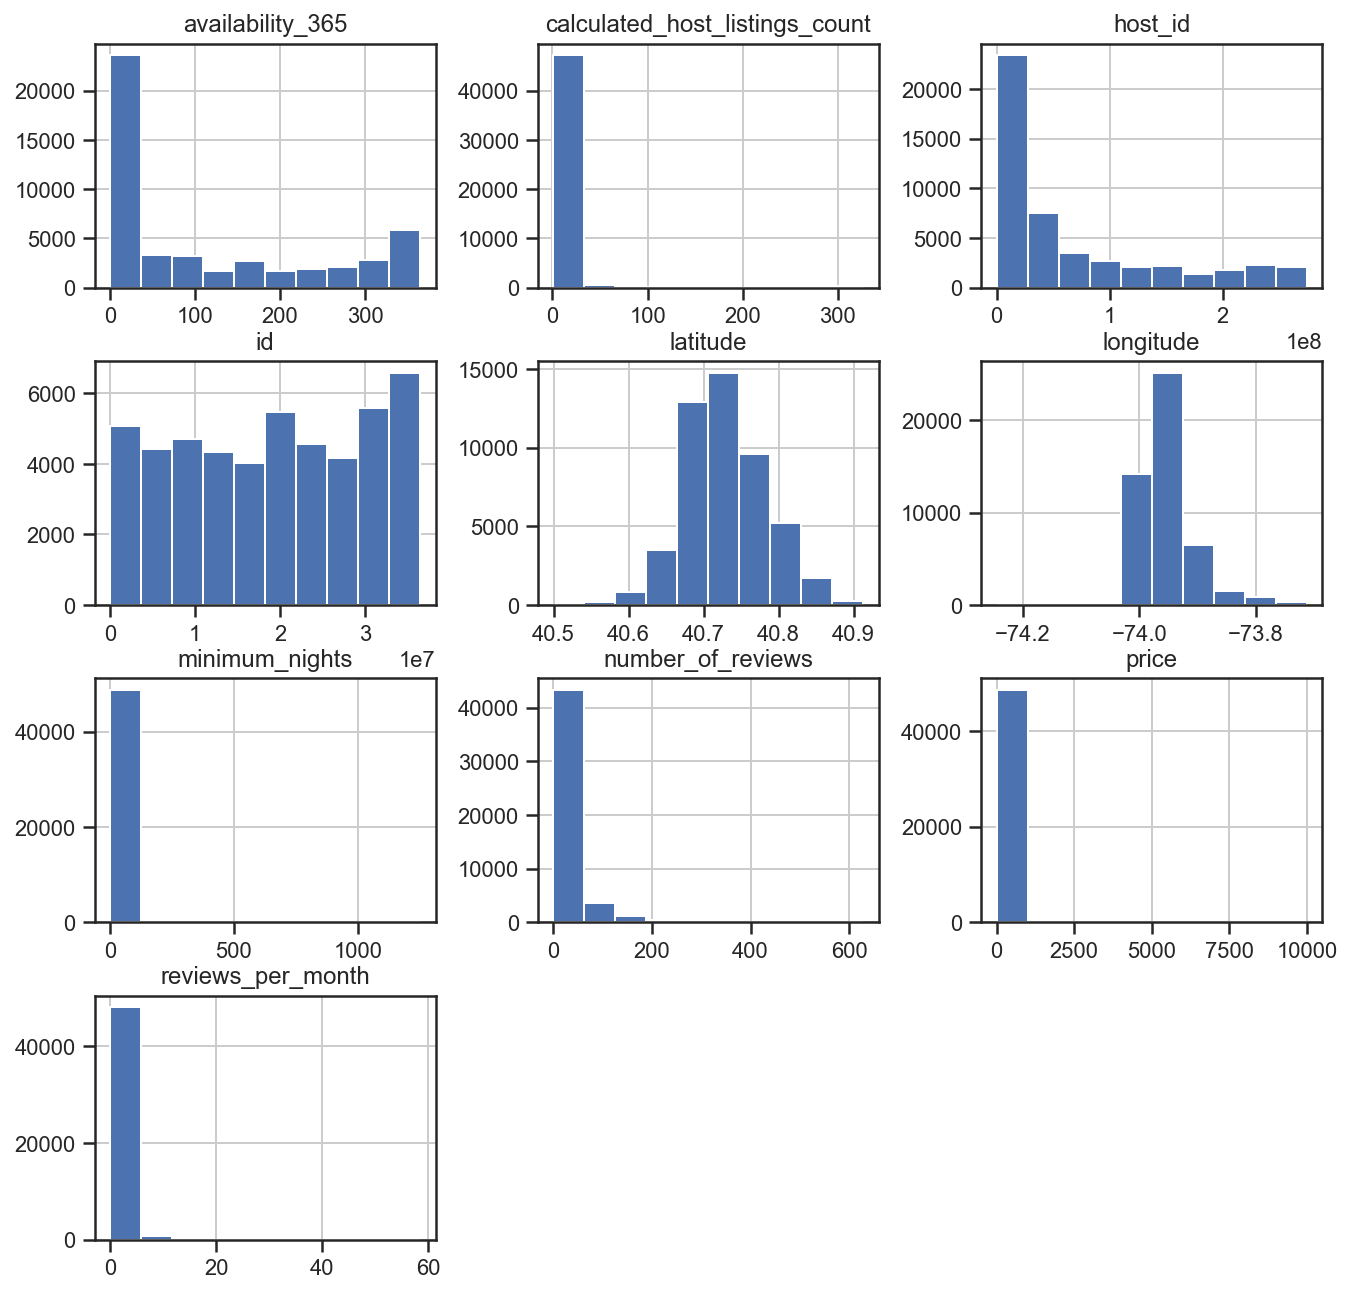

In [197]:
h = data.hist(figsize = (11, 11))
plt.savefig('hist.png')

### Target Variable: Price

In [198]:
# log transformation
data1 = data.copy()
data1['price'] = data1['price'].apply(np.log1p)

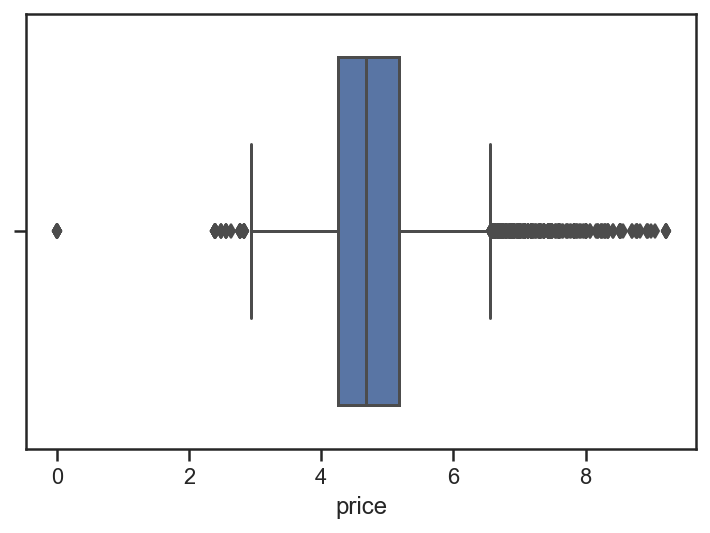

In [199]:
# check for possible outliers
b = sns.boxplot(data1['price'])
plt.savefig('box.png')

In [200]:
# use the 1.5 IQR rule to find outliers
def bounds(x):
    '''
    This funciton finds the lower and upper bounds for outliers in an array using the
    1.5IQR rule
    Input: x(array)
    Output: IQR, lower bound, upper bound
    '''
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    iqr = q3 - q1
    # finding upper and lower whiskers
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    return [iqr, lower, upper]

In [201]:
# how many observations are outside the bounds
_, lo, up = bounds(data1['price'])
print(lo, up)
print((data1['price'] < lo).sum(), (data1['price'] > up).sum())

2.8655121125661713 6.553467124521339
48 589


In [202]:
# remove outliers
data1 = data1[data1['price'] <= up]
data1 = data1[data1['price'] >= lo]

In [203]:
len(data1['price'])

48258

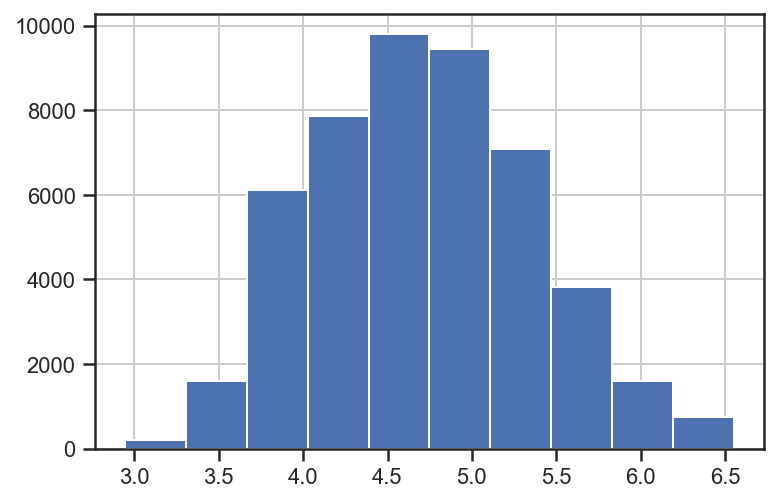

In [204]:
f = data1['price'].hist()
plt.savefig('price.png')

In [205]:
data1['price'].describe()

count    48258.000000
mean         4.710695
std          0.638671
min          2.944439
25%          4.248495
50%          4.663439
75%          5.170484
max          6.552508
Name: price, dtype: float64

### Features

#### ID and Host Name

In [206]:
# drop listing id and host name
data1.drop(columns = ['id', 'host_name'], inplace = True)

#### Neighbourhoods

In [207]:
data1['neighbourhood_group'].value_counts()

Manhattan        21204
Brooklyn         19961
Queens            5639
Bronx             1086
Staten Island      368
Name: neighbourhood_group, dtype: int64

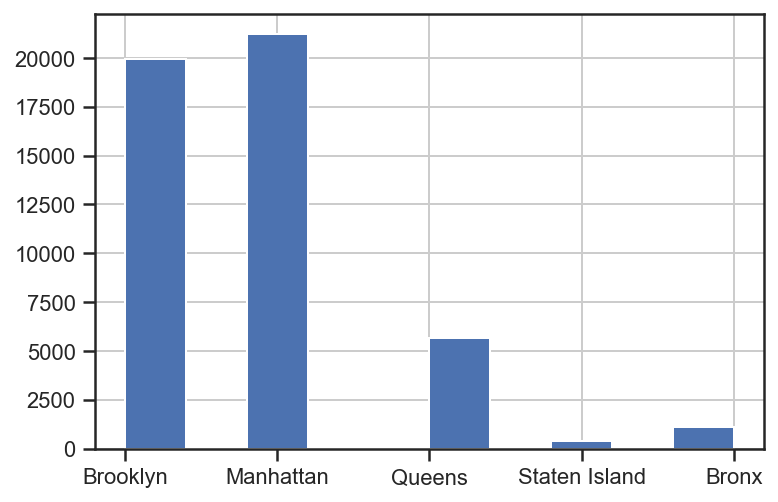

In [208]:
f = data1['neighbourhood_group'].hist()
plt.savefig('ng.png')

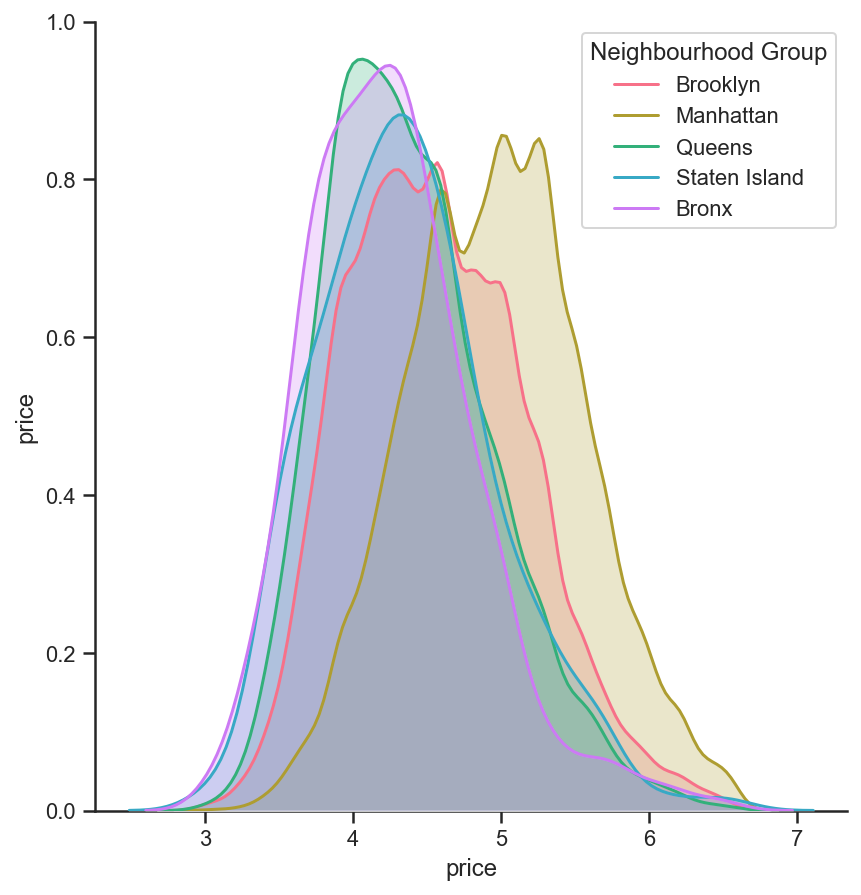

In [209]:
sns.set(style="ticks", color_codes=True)
f = sns.pairplot(data1[['neighbourhood_group', 'price']], hue = 'neighbourhood_group', palette='husl', height=6)
f._legend.remove()
plt.legend(title='Neighbourhood Group')
plt.savefig('ng_p.png')

In [210]:
data1.groupby('neighbourhood_group')['price'].mean().sort_values(ascending = False)

neighbourhood_group
Manhattan        4.966192
Brooklyn         4.564164
Queens           4.379428
Staten Island    4.360107
Bronx            4.254336
Name: price, dtype: float64

In [211]:
data1['neighbourhood'].value_counts().head(23)

Williamsburg                 3900
Bedford-Stuyvesant           3688
Harlem                       2639
Bushwick                     2454
Hell's Kitchen               1925
Upper West Side              1921
East Village                 1829
Upper East Side              1767
Crown Heights                1557
Midtown                      1464
East Harlem                  1112
Greenpoint                   1111
Chelsea                      1076
Lower East Side               904
Washington Heights            896
Astoria                       896
Financial District            736
West Village                  736
Flatbush                      617
Clinton Hill                  561
Long Island City              535
Prospect-Lefferts Gardens     530
Park Slope                    500
Name: neighbourhood, dtype: int64

In [212]:
# map less represented neighbourhoods to 'Others'
(data1['neighbourhood'].value_counts() < 500).sum()

197

In [213]:
n = data1['neighbourhood'].value_counts()
other = n[n < 500].index.to_list()
data1['neighbourhood'] = data1['neighbourhood'].replace(other, 'Others')

In [214]:
data1['neighbourhood'].value_counts()

Others                       14904
Williamsburg                  3900
Bedford-Stuyvesant            3688
Harlem                        2639
Bushwick                      2454
Hell's Kitchen                1925
Upper West Side               1921
East Village                  1829
Upper East Side               1767
Crown Heights                 1557
Midtown                       1464
East Harlem                   1112
Greenpoint                    1111
Chelsea                       1076
Lower East Side                904
Washington Heights             896
Astoria                        896
Financial District             736
West Village                   736
Flatbush                       617
Clinton Hill                   561
Long Island City               535
Prospect-Lefferts Gardens      530
Park Slope                     500
Name: neighbourhood, dtype: int64

In [215]:
data1.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean()

neighbourhood_group  neighbourhood            
Bronx                Others                       4.254336
Brooklyn             Bedford-Stuyvesant           4.438146
                     Bushwick                     4.279069
                     Clinton Hill                 4.779288
                     Crown Heights                4.497130
                     Flatbush                     4.325719
                     Greenpoint                   4.754851
                     Others                       4.603975
                     Park Slope                   4.951702
                     Prospect-Lefferts Gardens    4.451869
                     Williamsburg                 4.756040
Manhattan            Chelsea                      5.222008
                     East Harlem                  4.645947
                     East Village                 5.005587
                     Financial District           5.262750
                     Harlem                       4.556415
         

#### Room Type

In [216]:
data1['room_type'].value_counts()

Entire home/apt    24906
Private room       22211
Shared room         1141
Name: room_type, dtype: int64

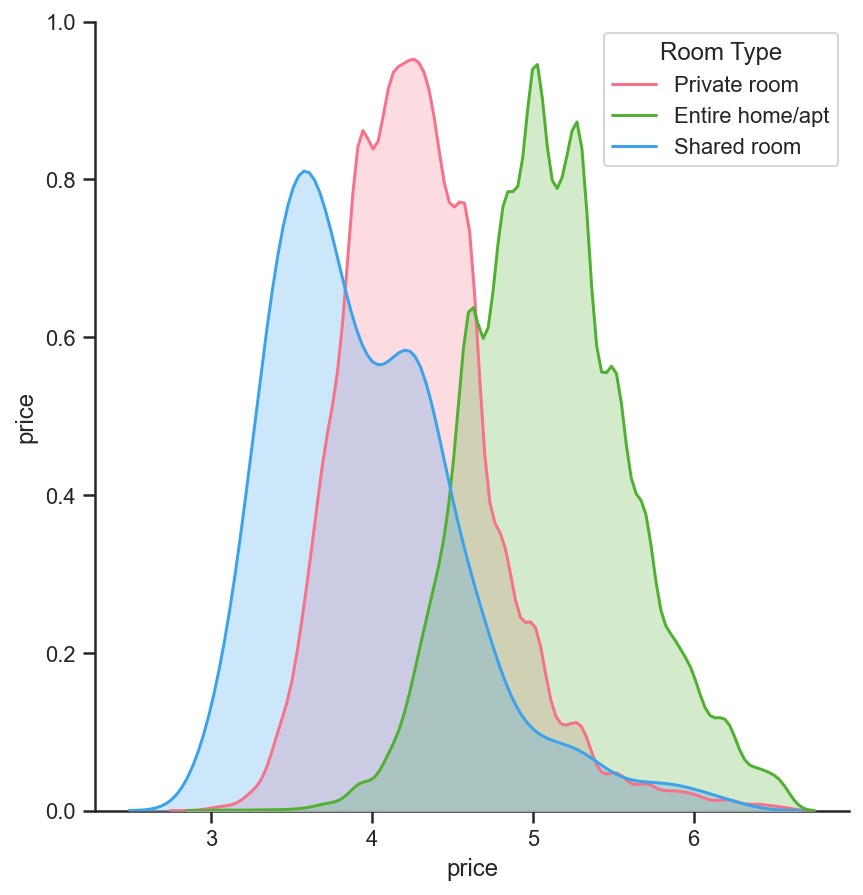

In [217]:
# relationships between price and room type
f = sns.pairplot(data1[['room_type', 'price']], hue = 'room_type', palette='husl', height=6)
f._legend.remove()
plt.legend(title='Room Type')
plt.savefig('room.png')

In [218]:
data1.groupby('room_type')['price'].mean()

room_type
Entire home/apt    5.111421
Private room       4.299630
Shared room        3.965452
Name: price, dtype: float64

#### Last Review

In [219]:
data1['last_review'] = data['last_review'].fillna("None")

In [220]:
data1['last_review'][data1['last_review'] != 'None']

0        2018-10-19
1        2019-05-21
3        2019-07-05
4        2018-11-19
5        2019-06-22
            ...    
48782    2019-07-07
48790    2019-07-07
48799    2019-07-07
48805    2019-07-07
48852    2019-07-08
Name: last_review, Length: 38495, dtype: object

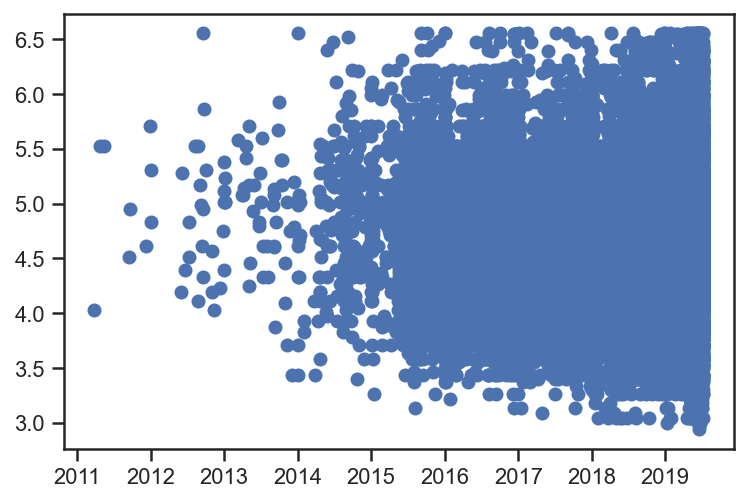

In [221]:
# relationship between last review time and price
x = data1['last_review'][data1['last_review']!= 'None'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
y = data1['price'][data1['last_review']!= 'None']
plt.scatter(x, y)
plt.show()

In [222]:
# no clear relationship so we drop this column 
data1.drop(columns = ['last_review'], inplace = True)

#### Host ID

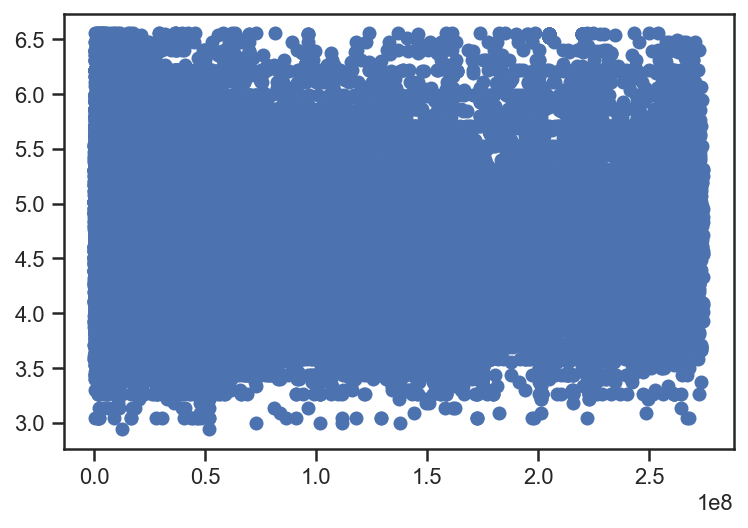

In [223]:
# relationship between host ID and price
plt.scatter(data1['host_id'], data1['price'])
plt.show()

In [224]:
# no clear relationship so drop
data1.drop(columns = ['host_id'], inplace = True)

#### Minimum Nights

In [225]:
data1['minimum_nights'].describe()

count    48258.000000
mean         6.972481
std         20.273999
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [226]:
(data1['minimum_nights'] > 35).sum()

495

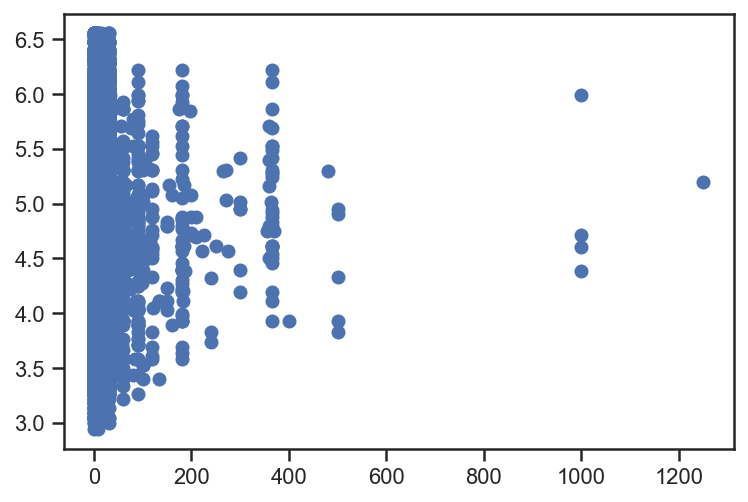

In [227]:
# relationship between min nights and price
plt.scatter(data1['minimum_nights'], data1['price'])
plt.show()

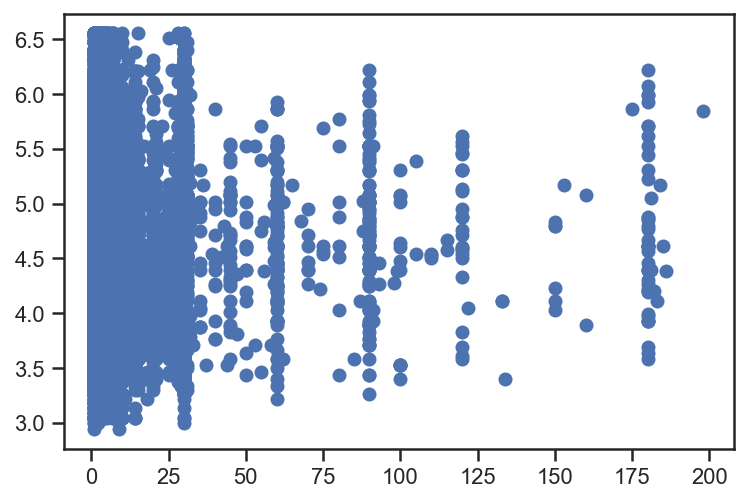

In [228]:
# only look at min_nights < 200
plt.scatter(data1['minimum_nights'][data1['minimum_nights'] < 200], data1['price'][data1['minimum_nights'] < 200])
plt.show()

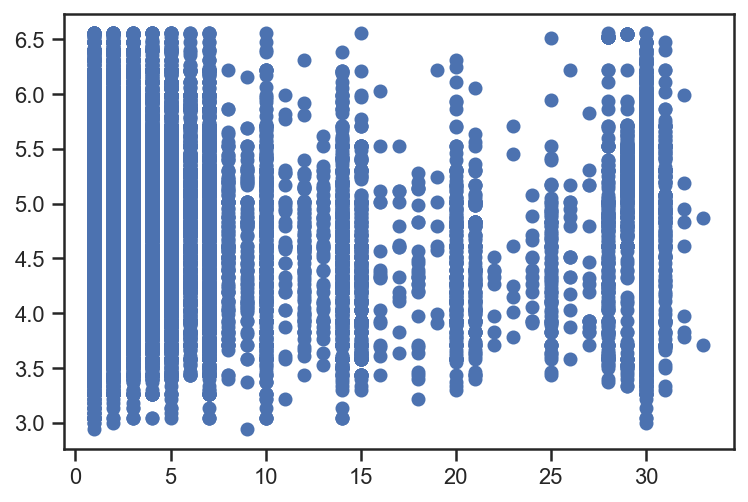

In [229]:
# only look at min_nights < 35
plt.scatter(data1['minimum_nights'][data1['minimum_nights'] < 35], data1['price'][data1['minimum_nights'] < 35])
plt.show()

In [230]:
# replace min nights > 35 with 35
data1.loc[(data1['minimum_nights'] > 35), 'minimum_nights'] = 35

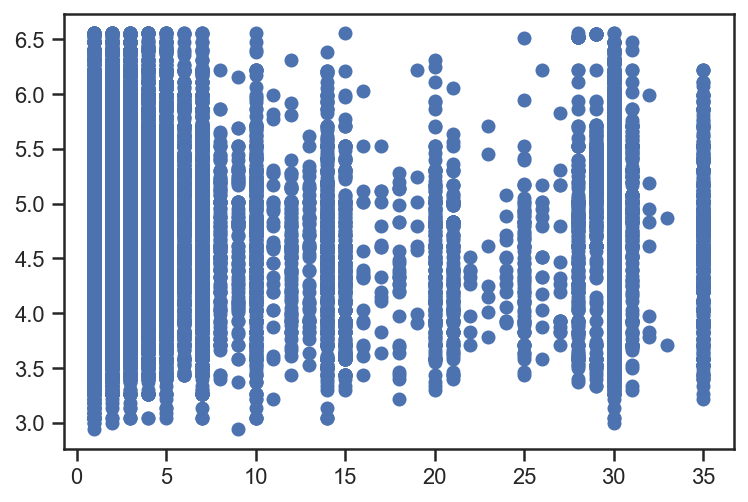

In [231]:
plt.scatter(data1['minimum_nights'], data1['price'])
plt.show()

In [232]:
data1['minimum_nights'].describe()

count    48258.000000
mean         5.994861
std          8.824786
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         35.000000
Name: minimum_nights, dtype: float64

#### Number of Reviews

In [233]:
data1['number_of_reviews'].describe()

count    48258.000000
mean        23.460504
std         44.750609
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: number_of_reviews, dtype: float64

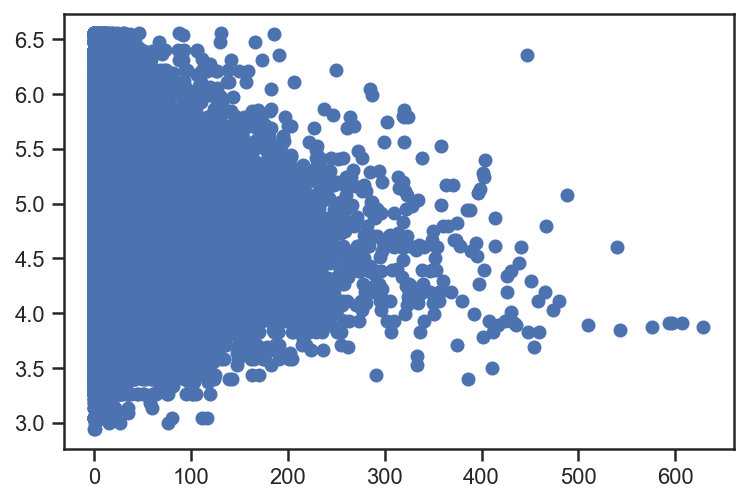

In [234]:
plt.scatter(data1['number_of_reviews'], data1['price'])

In [235]:
# replace number of reviews > 400 with 400
data1.loc[(data1['number_of_reviews'] > 400), 'number_of_reviews'] = 400

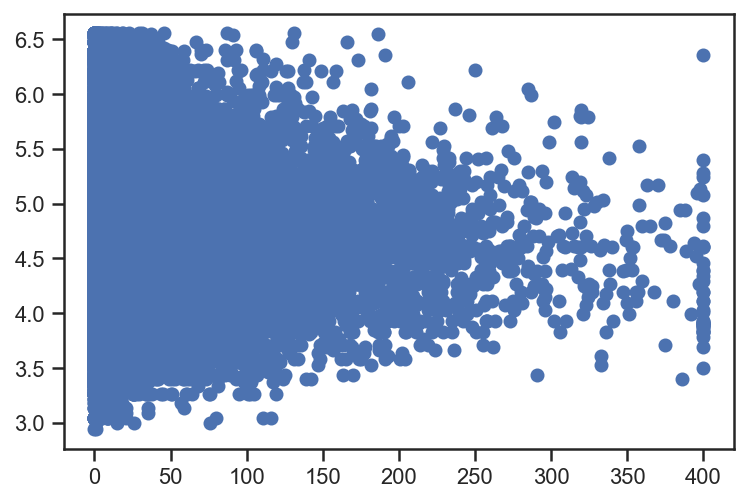

In [236]:
plt.scatter(data1['number_of_reviews'], data1['price'])

#### Reviews Per Month

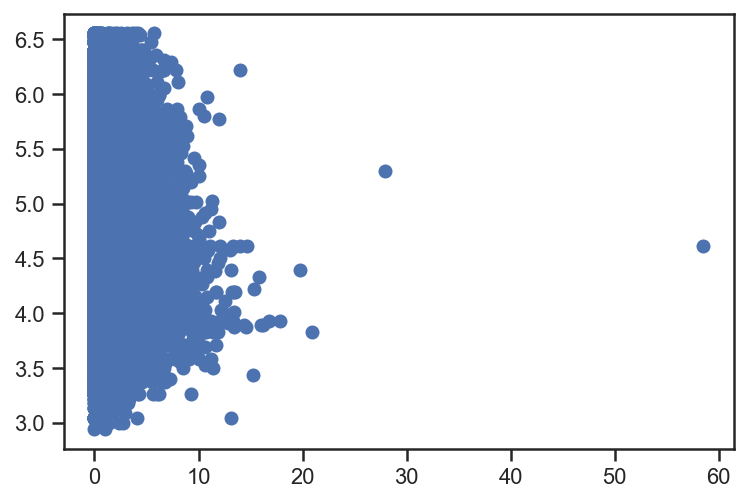

In [237]:
plt.scatter(data1['reviews_per_month'], data1['price'])

In [238]:
# remove data where review per month < 15
data1 = data1[data1.reviews_per_month < 15]

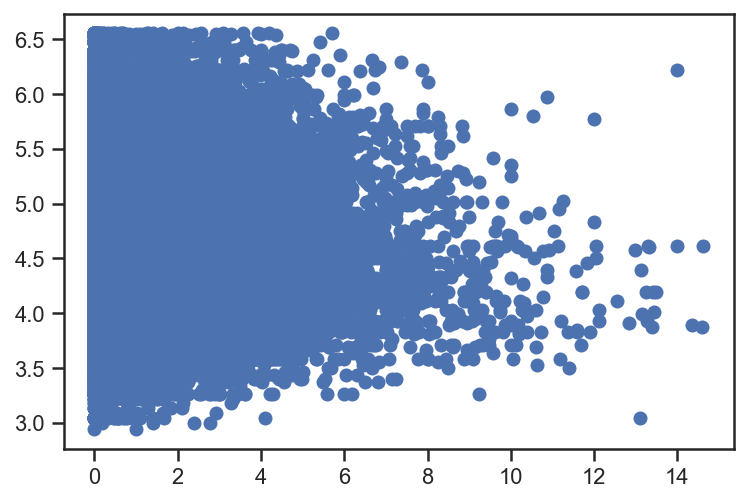

In [239]:
plt.scatter(data1['reviews_per_month'], data1['price'])

#### Calculated Host Listing Count

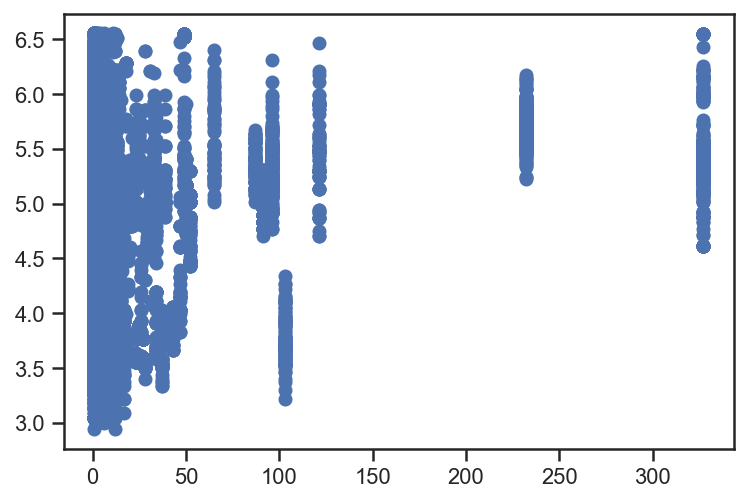

In [240]:
# might have some relationship
plt.scatter(data1['calculated_host_listings_count'], data1['price'])
plt.show()

#### availability_365

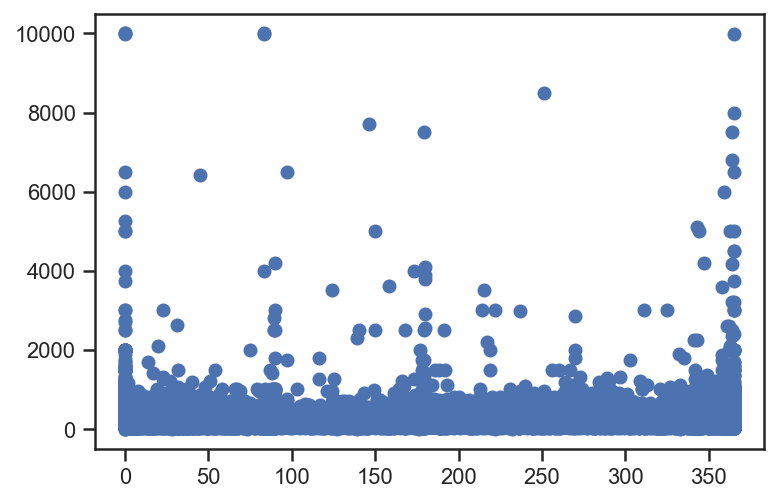

In [241]:
plt.scatter(data['availability_365'], data['price'])
plt.show()

In [242]:
# drop 
data1.drop(columns = ['availability_365'], inplace = True)

#### Longitude and latitude

In [243]:
# drop 
data1.drop(columns = ['longitude', 'latitude'], inplace = True)

In [244]:
data1.drop(columns = ['name'], inplace = True)

### Numerical Features

In [81]:
numf = data1.select_dtypes(exclude=['object'])

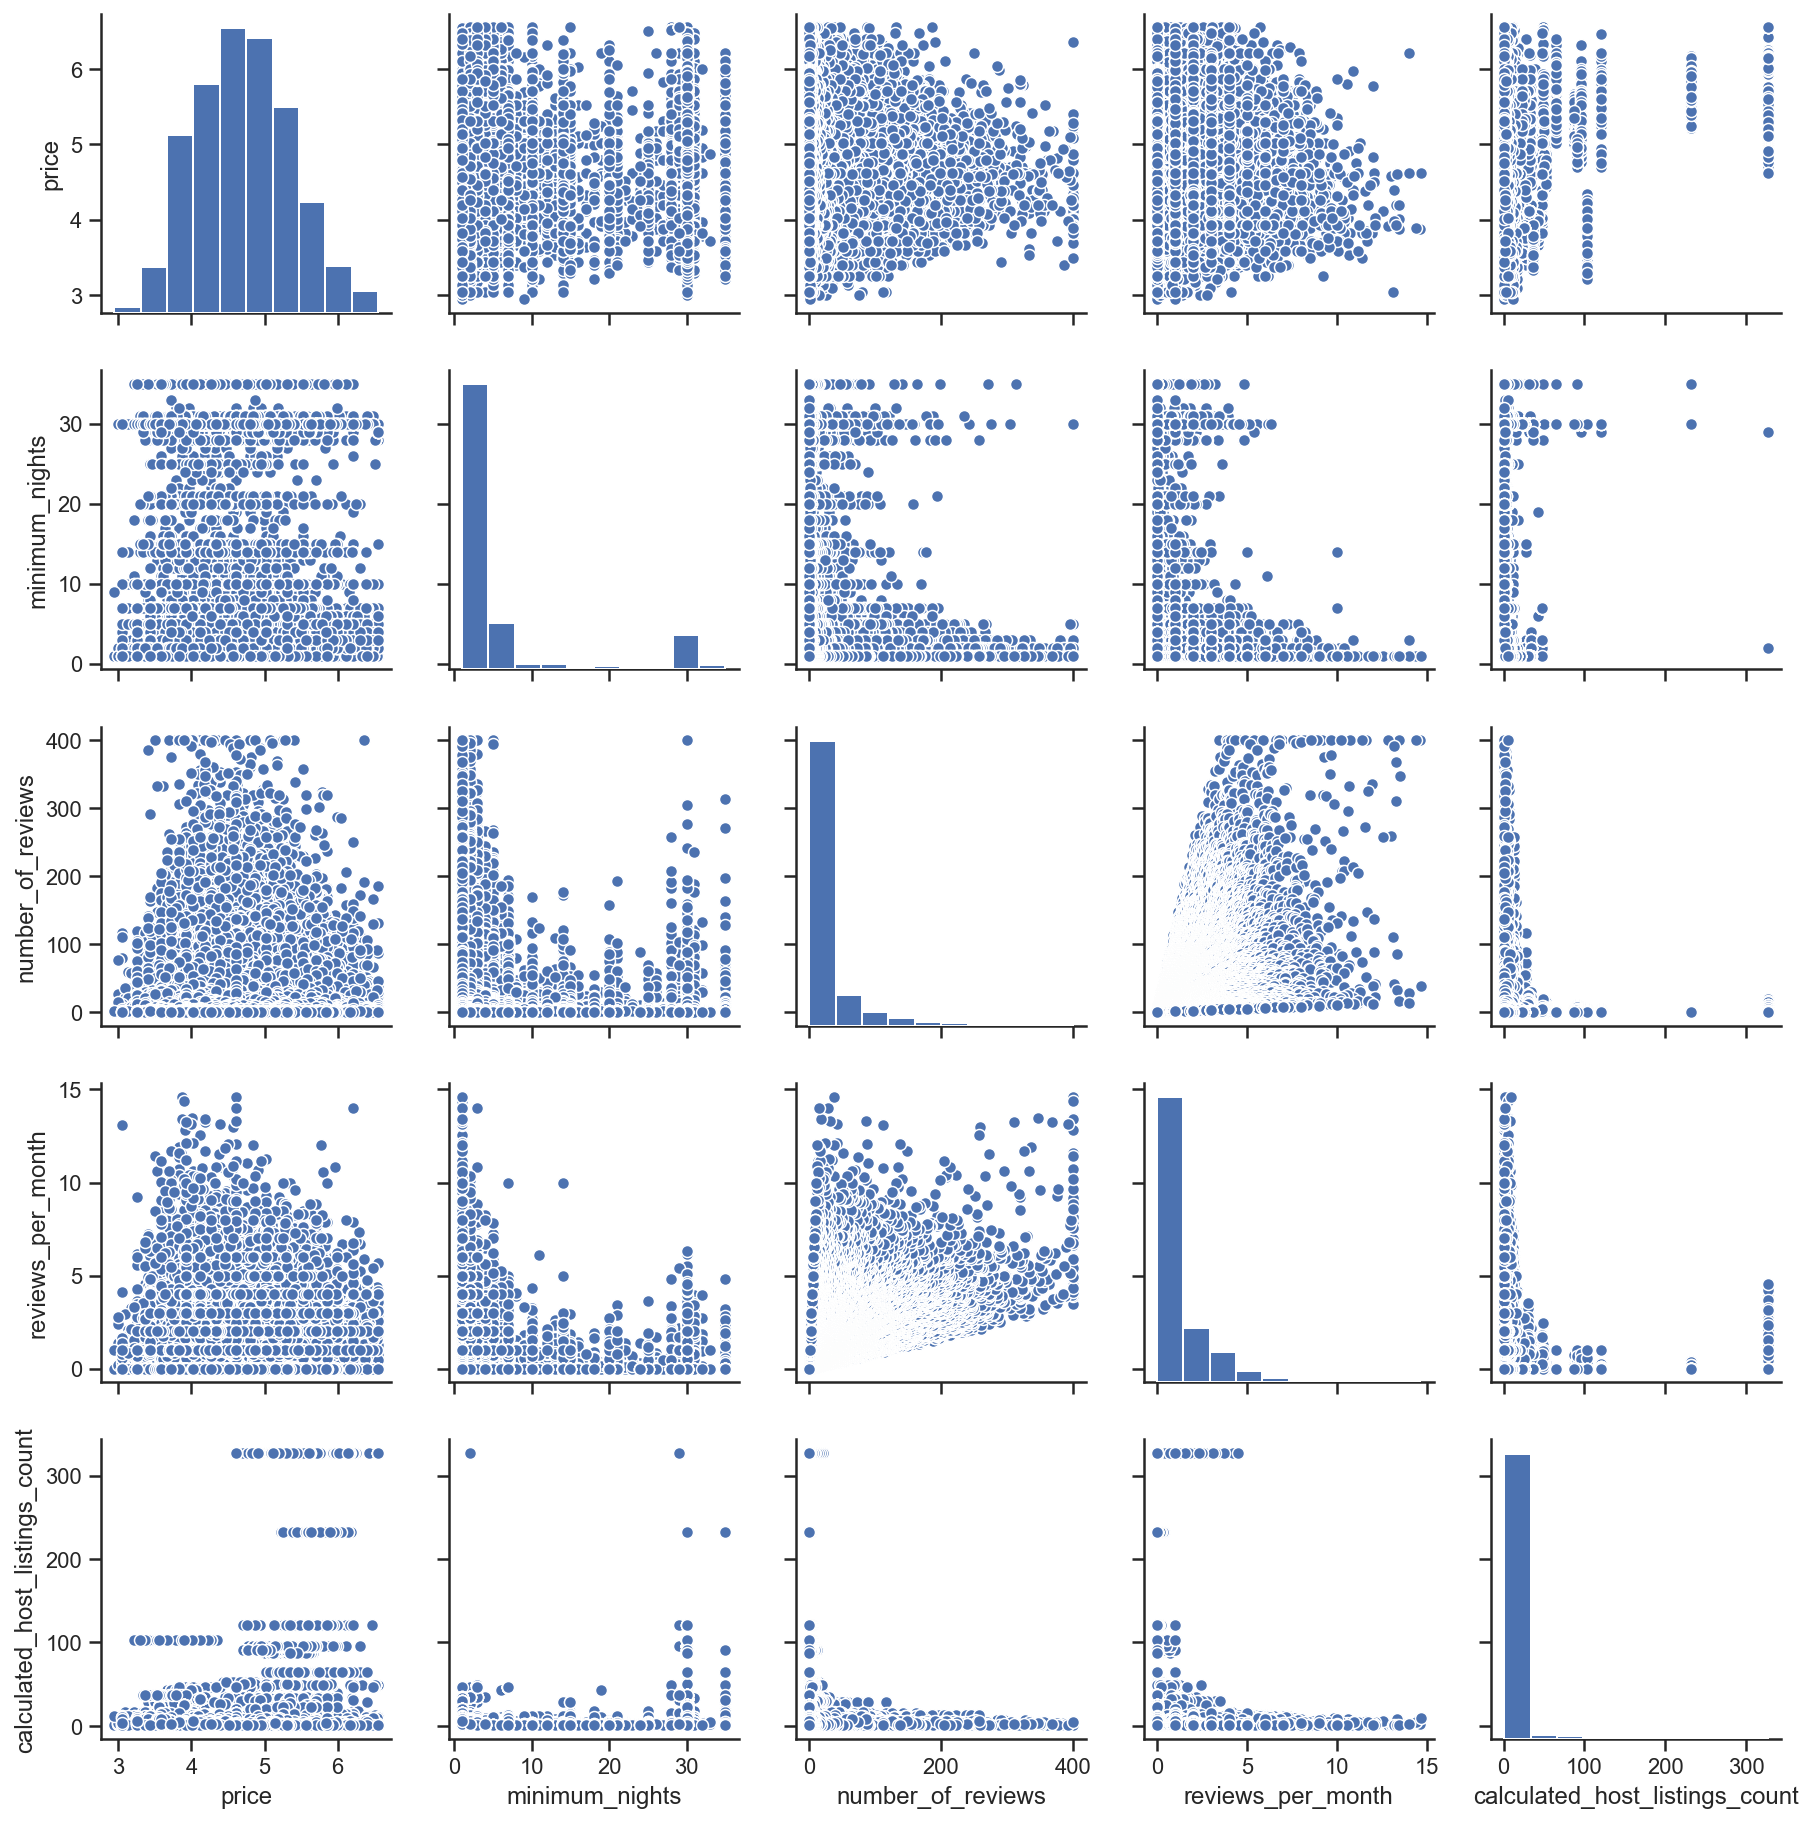

In [82]:
sns.pairplot(numf)
plt.savefig('pair.png')

## Feature Engineering

### One-hot Encoding

In [245]:
oh_cols = data1.dtypes[data1.dtypes == np.object] 
oh_cols = oh_cols.index.to_list()

In [246]:
data1[oh_cols]

,neighbourhood_group,neighbourhood,room_type
0,Brooklyn,Others,Private room
1,Manhattan,Midtown,Entire home/apt
2,Manhattan,Harlem,Private room
3,Brooklyn,Clinton Hill,Entire home/apt
4,Manhattan,East Harlem,Entire home/apt
...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,Private room
48891,Brooklyn,Bushwick,Private room
48892,Manhattan,Harlem,Entire home/apt
48893,Manhattan,Hell's Kitchen,Shared room


In [247]:
X = pd.get_dummies(data1, columns = oh_cols, drop_first = True)

In [248]:
X.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Bedford-Stuyvesant,...,neighbourhood_Others,neighbourhood_Park Slope,neighbourhood_Prospect-Lefferts Gardens,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Washington Heights,neighbourhood_West Village,neighbourhood_Williamsburg,room_type_Private room,room_type_Shared room
0,5.010635,1,9,0.21,6,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,5.420535,1,45,0.38,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.017280,3,0,0.00,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4.499810,1,270,4.64,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.394449,10,9,0.10,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


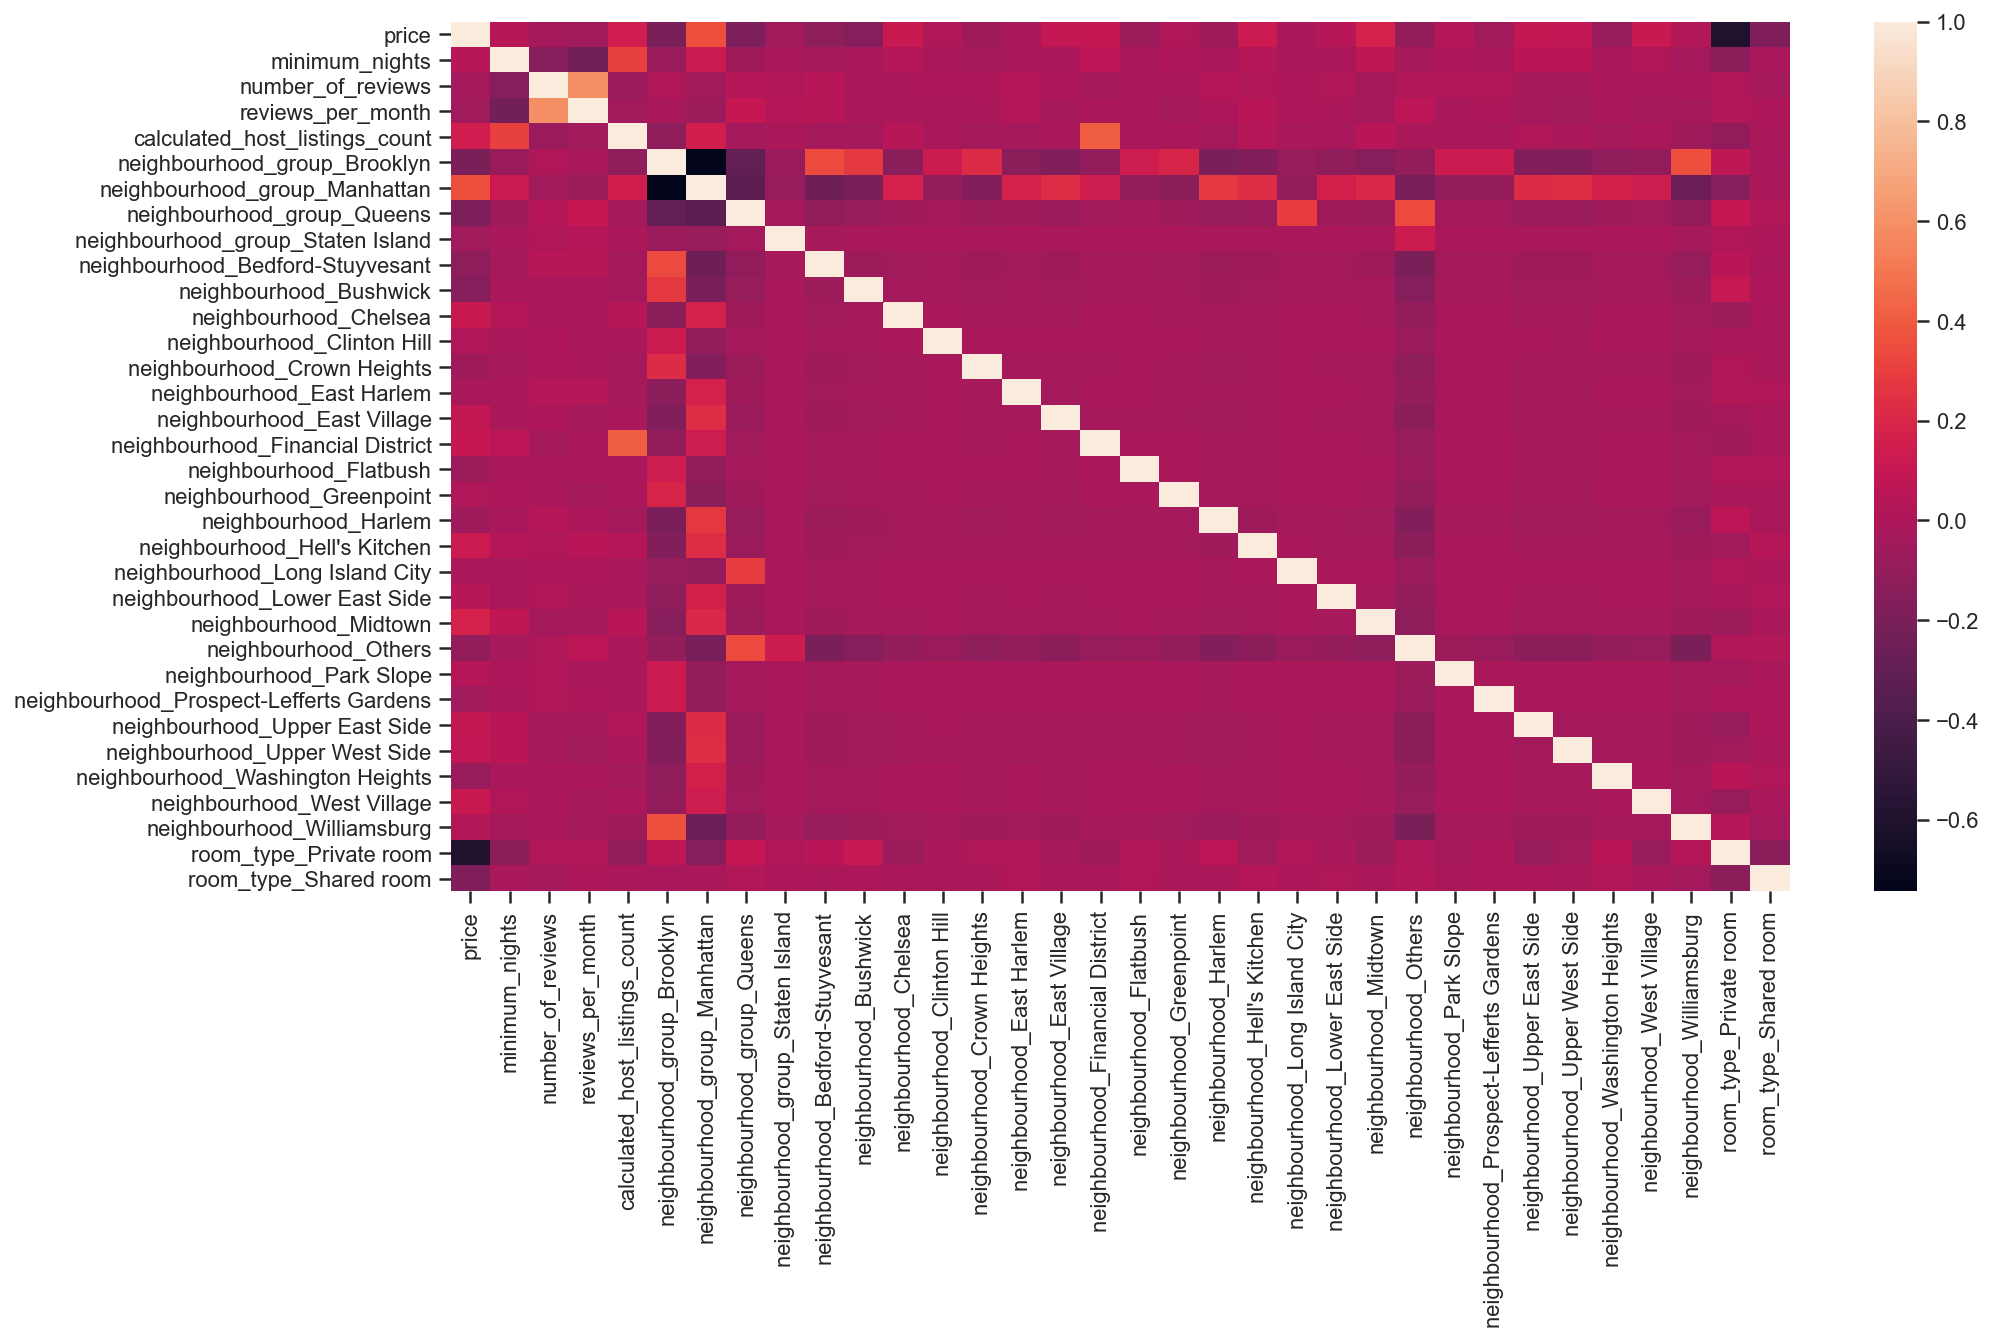

In [101]:
corr = X.corr(method='pearson')
plt.figure(figsize=(15,8))
sns.heatmap(corr)
plt.savefig('heat.png')

## Training and Prediction

In [249]:
y = X['price']
X.drop(columns = ['price'], inplace = True)

### Prepare for training 

In [250]:
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 786)

In [251]:
s = StandardScaler()
lr = LinearRegression()
kf = KFold(shuffle = True, random_state = 701, n_splits = 5) # 5 fold cross validation

### Linear Regression

In [142]:
# first use a simple linear regression as a base line
estimator1 = Pipeline([('scaler', s), ('regression', lr)])
# estimator1.fit(X_train, y_train)

In [143]:
pred1 = cross_val_predict(estimator1, X_train, y_train,cv = kf)

In [144]:
r2_1 = r2_score(y_train, pred1)
mse1 = mean_squared_error(y_train, pred1)

In [145]:
print(r2_1, mse1)

0.5543662140733447 0.18138962444498163


### Polynomial Regression

In [146]:
# add polynomial features to the regression

pf = PolynomialFeatures(degree = 2)
estimator2 = Pipeline([('scaler', s), ('make_higher_degree', pf), ('regression', lr)])

pred = cross_val_predict(estimator2, X_train, y_train, cv = kf)
r2 = r2_score(y_train, pred)
mse = mean_squared_error(y_train, pred)


In [147]:
print(r2, mse)

0.5689342859819477 0.17545987410773067


### Lasso

In [163]:
# add L1 regularization
alpha = [1e-4, 0.001, 0.01, 0.1] # only try this range due to limited computing power
score3 = []
pf = PolynomialFeatures(degree = 2)
for a in alpha:
    las = Lasso(alpha = a, max_iter=100000)
    estimator3 = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])
    pred = cross_val_predict(estimator3, X_train, y_train, cv = kf)
    r2 = r2_score(y_train, pred)
    mse = mean_squared_error(y_train, pred)
    score3.append([r2, mse])
    print(a)

0.0001
0.001
0.01
0.1


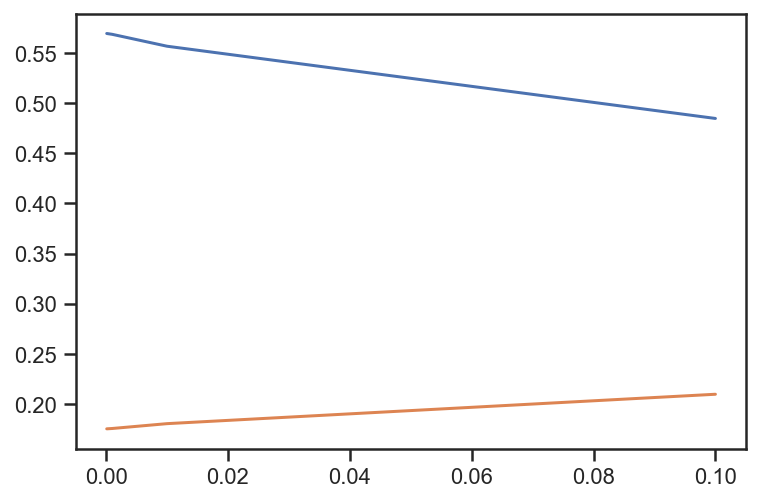

In [164]:
r2 = []
mse = []
for s in score3:
    r2.append(s[0])
    mse.append(s[1])
    
plt.plot(alpha, r2)
plt.plot(alpha, mse)

In [165]:
r2[0]

0.5693949672891847

In [166]:
mse[0]

0.17527235957910317

In [252]:
# use lasso in the whole training set
pf = PolynomialFeatures(degree = 2)
ls = Lasso(alpha = 1e-4, max_iter = 100000)
best_est = Pipeline( [('scaler', s), 
                     ('make_higher_degree', pf),
                      ('lasso_regression', ls) ])
best_est.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('make_higher_degree', PolynomialFeatures()),
                ('lasso_regression', Lasso(alpha=0.0001, max_iter=100000))])

In [253]:
# get the score and parameters
coefs = best_est.named_steps["lasso_regression"].coef_
print(best_est.score(X_train, y_train))

0.575449462077845


### Prediction

In [254]:
ypred = best_est.predict(X_test)
mse_test = mean_squared_error(ypred, y_test)

In [255]:
mse_test

0.17491007352138446

In [256]:
best_est.score(X_test, y_test)

0.573089128185968

## Feature Importance

In [269]:
coef = pd.DataFrame(columns = ['Feature', 'Coefficient'])
coef['Feature'] = pf.get_feature_names(X_train.columns)
coef['Coefficient'] = coefs

In [271]:
# select the features whose coefficient are not zero
coef = coef[coef['Coefficient'] != 0]
coef.set_index('Feature', inplace = True)

In [276]:
# sort by absolute value of coef
coef['Abs Coef'] = coef['Coefficient'].abs()
coef.sort_values(by = ['Abs Coef'], ascending = False, inplace = True)

In [ ]:
# plot the 50 most important features

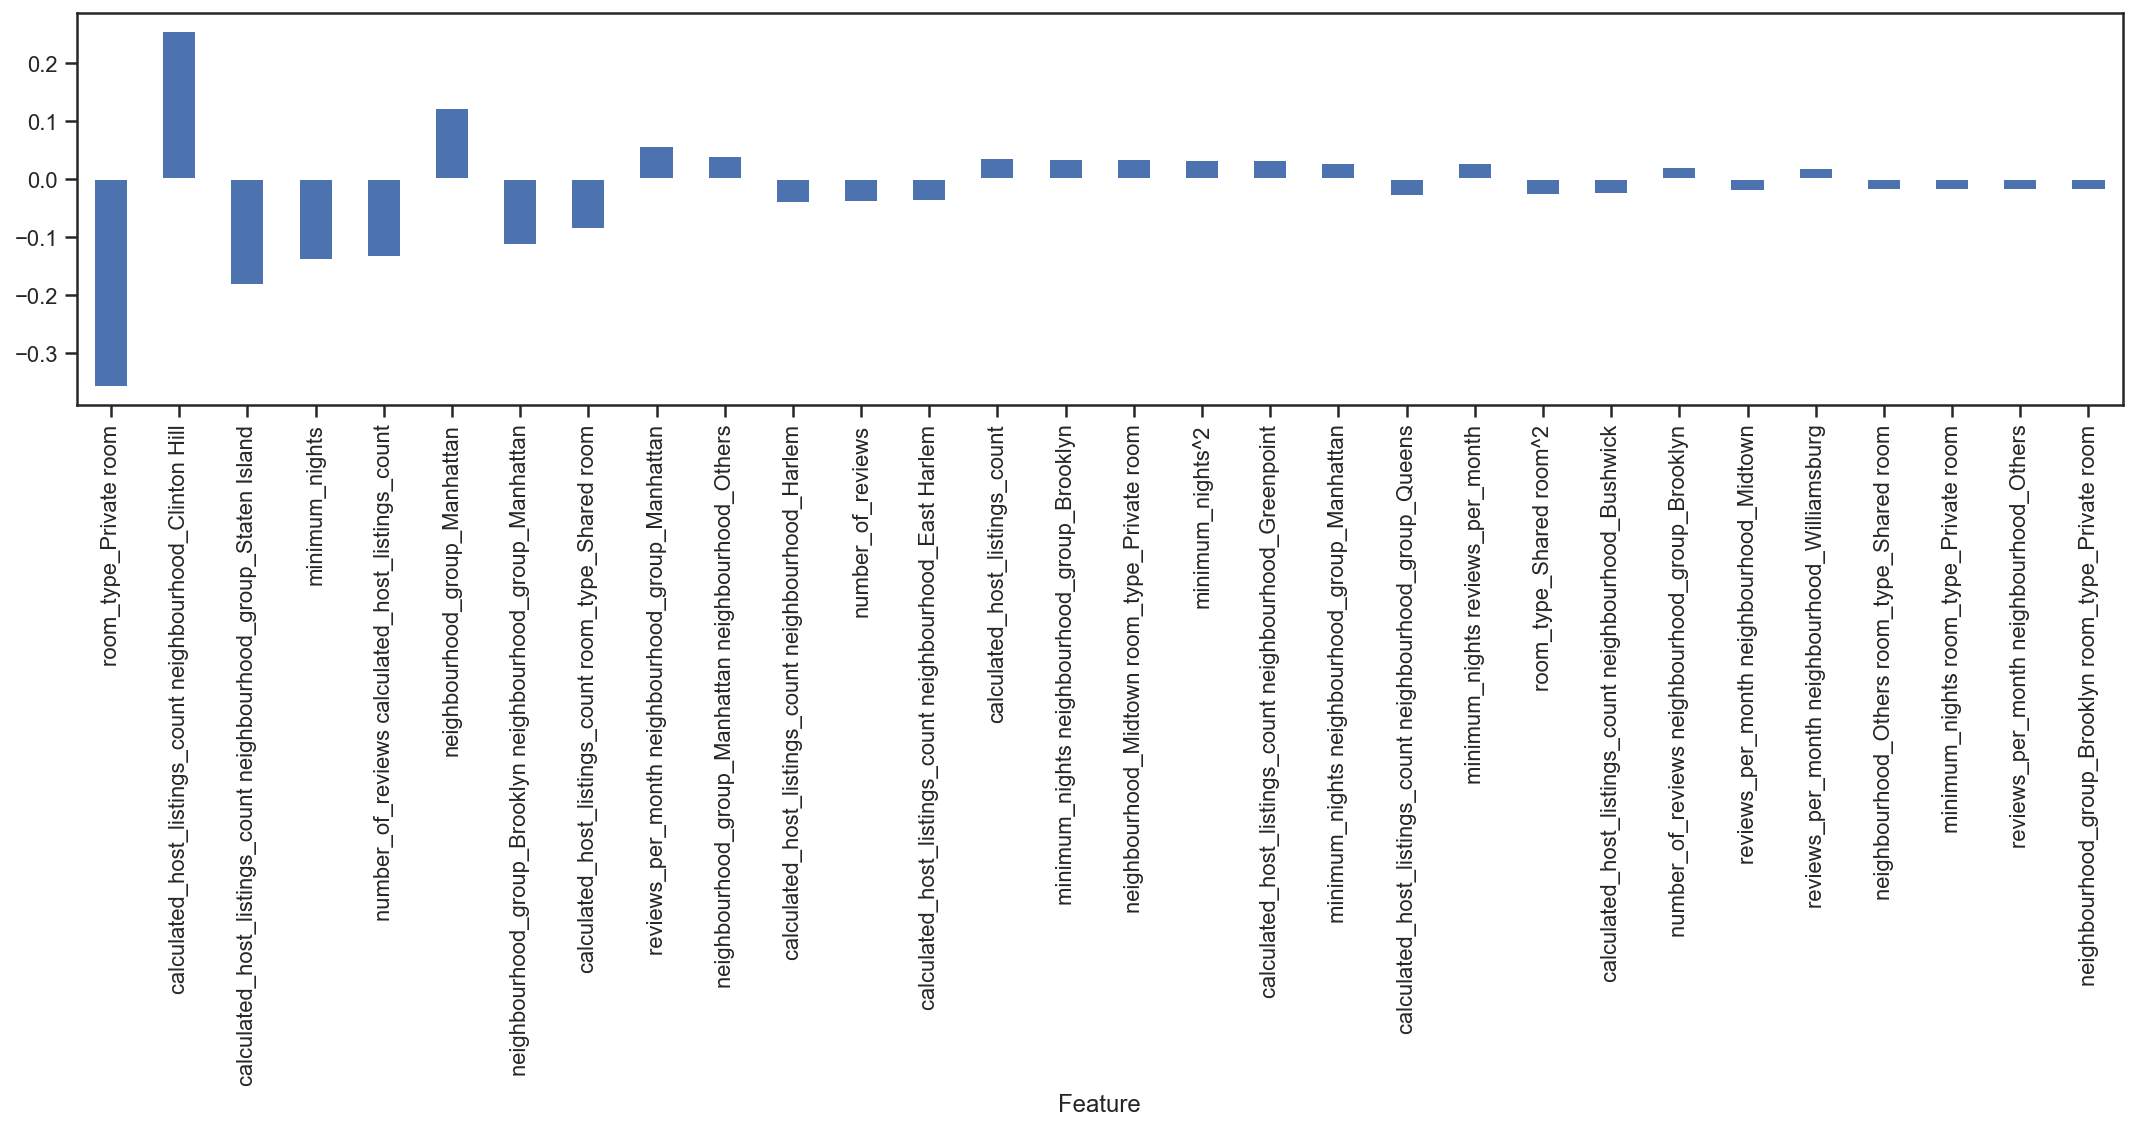

In [292]:
impf = coef[:30]['Coefficient']

impf.plot.bar(rot=90, figsize = (15, 8))
plt.tight_layout()
plt.savefig('import.png')

In [298]:
# top 8 features
impf[:8].index.tolist()

['room_type_Private room',
 'calculated_host_listings_count neighbourhood_Clinton Hill',
 'calculated_host_listings_count neighbourhood_group_Staten Island',
 'minimum_nights',
 'number_of_reviews calculated_host_listings_count',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Brooklyn neighbourhood_group_Manhattan',
 'calculated_host_listings_count room_type_Shared room']